### Imports

In [1]:
import pandas as pd
import numpy as np 
import QAOA_Tester as qtee
import os

### Functions

In [2]:
def combine_dfs(dfs):
    combined_df = pd.concat(dfs)
    combined_df.drop(columns='Unnamed: 0', inplace=True)

    # The index should be the number of layers
    combined_df.set_index('layers', inplace=True)
    # Sort the index
    combined_df.sort_index(inplace=True)
    return combined_df

In [3]:
def load_dfs_from(dir_name):
    files_in_dir = os.listdir(dir_name)
    files_in_dir = [file for file in files_in_dir if file.endswith('.csv')]
    dfs = []
    for file_name in files_in_dir:
        dfs.append(pd.read_csv(f'{dir_name}/{file_name}'))
    
    return dfs

    

In [4]:
def reverse_results(df):
    problem_data = df.iloc[0]['problem']
    problem_data = eval(problem_data)
    problem = qtee.ProblemGenerator.from_dict(problem_data)
    def reverse_and_evaluate(solution):
        if type(solution) == str:
            solution = eval(solution)
            reversed_solutions = []
            for sol in solution:
                reversed_solution = sol[0][::-1]
                reversed_cost = problem.qubo.objective.evaluate(reversed_solution)
                reversed_solutions.append((reversed_solution, reversed_cost))
            return reversed_solutions
        elif type(solution) == None:
            return None
    
    reversed_df = df.copy()
    reversed_df['solutions'] = df['solutions'].apply(lambda x: reverse_and_evaluate(x))
    return reversed_df
    

In [47]:
def compute_average_cost_and_time(df):
    # Group all rows by the number of layers
    grouped_df = df.groupby('layers')
    # Get all solutions for each layer
    solutions = grouped_df['solutions'].apply(lambda x: [item for sublist in x for item in sublist])
    
    # Get all times for each layer and handle different formats
    def flatten_times(times):
        if isinstance(times.iloc[0], list):
            return [item for sublist in times for item in sublist]
        elif isinstance(times.iloc[0], str):
            return [float(item) for sublist in times for item in eval(sublist)]
        else:
            return times.tolist()

    times = grouped_df['time'].apply(flatten_times)
    
    # Initialize lists to store costs and times
    costs = []
    avg_times = []
    non_cost_layers = []
    # Iterate over each layer's solutions
    for layer, solution in solutions.items():
        layer_cost = 0
        count = 0
        none_count = 0
        for rep in solution:
            if isinstance(rep, list) and isinstance(rep[0], tuple):
                # Structure is a list of tuples
                layer_cost += sum([sol[1] for sol in rep])
                count += len(rep)
            elif isinstance(rep, tuple):
                # Structure is a single tuple
                # print(rep[1])
                # Count the number of non valid solutions
                if rep[1] is not None:
                    layer_cost += rep[1]
                else:
                    none_count += 1
                #
                count += 1
                    
        # Compute the average cost for the layer
        if count > 0:
            layer_cost /= count
        costs.append((layer, layer_cost))
        non_cost_layers.append((layer, count - none_count))

    # Iterate over each layer's times
    for layer, time in times.items():
        avg_time = sum(time) / len(time)
        avg_times.append((layer, avg_time))

    # Combine costs and times into a single DataFrame
    costs_df = pd.DataFrame(costs, columns=['layers', 'cost'])
    times_df = pd.DataFrame(avg_times, columns=['layers', 'average_time'])
    none_count = pd.DataFrame(non_cost_layers, columns=['layers', 'none_count'])
    result_df = costs_df.merge(times_df, on='layers').merge(none_count, on='layers')

    return result_df

In [6]:
import matplotlib.pyplot as plt

def plot_average_costs(data, best_cost=None, custom_colors=False, custom_legend=None):
    if custom_colors:
        colors = qtee.utils.custom_colors
        key_to_color = {'Optimal Backend': 'blue', 'Noisy Backend': 'orange'}
        for key, df in data.items():
            plt.plot(df['layers'], -df['cost'], label=key, color=colors[key_to_color[key]]['dark'])
    else:
        for key, df in data.items():
            plt.plot(df['layers'], -df['cost'], label=key)
            
    if best_cost:
        point1 = (1, best_cost)
        point2 = (30, best_cost)
        max_value_line = [point1, point2]
        plt.plot(*zip(*max_value_line), color='red', linestyle='--', label='Best Cost')
        plt.ylim(0, best_cost+ 0.1*best_cost)
    plt.xlabel('Layers')
    plt.ylabel('Average Cost')
    if custom_legend:
        plt.legend(custom_legend)
    else:
        plt.legend()
    return plt


In [7]:
def plot_average_times(data):
    colors = qtee.utils.custom_colors
    key_to_color = {'Optimal Backend': 'blue', 'Noisy Backend': 'orange'}
    for key, df in data.items():
        plt.plot(df['layers'], df['average_time'], label=key, color=colors[key_to_color[key]]['dark'])
    plt.xlabel('Layers')
    plt.ylabel('Average Time (s)')
    plt.legend()
    return plt

In [8]:
def get_costs_and_times(df):
    # Group all rows by the number of layers
    grouped_df = df.groupby('layers')
    # Get all solutions for each layer
    solutions = grouped_df['solutions'].apply(lambda x: [item for sublist in x for item in sublist])
    
    # Get all times for each layer and handle different formats
    def flatten_times(times):
        if isinstance(times.iloc[0], list):
            return [item for sublist in times for item in sublist]
        elif isinstance(times.iloc[0], str):
            return [float(item) for sublist in times for item in eval(sublist)]
        else:
            return times.tolist()

    times = grouped_df['time'].apply(flatten_times)
    
    # Initialize lists to store costs and times
    costs = []
    time_list = []
    # Iterate over each layer's solutions
    for layer, solution in solutions.items():
        layer_cost = []
        
        for rep in solution:
            if isinstance(rep, list) and isinstance(rep[0], tuple):
                # Structure is a list of tuples
                layer_cost.extend([-sol[1] for sol in rep])
            elif isinstance(rep, tuple):
                # Structure is a single tuple
                layer_cost.append(-rep[1])
        costs.append((layer, layer_cost))
    
    # Iterate over each layer's times
    for layer, time in times.items():
        time_list.append((layer, time))

    # Combine costs and times into a single DataFrame
    costs_df = pd.DataFrame(costs, columns=['layers', 'cost'])
    times_df = pd.DataFrame(time_list, columns=['layers', 'times'])
    result_df = costs_df.merge(times_df, on='layers')
    
    return result_df

In [9]:
import seaborn as sns
def plot_average_costs_with_ci(data, best_cost=None, percentile=80, smoothing_factor=1):
    colors = qtee.utils.custom_colors
    key_to_color = {'Optimal Backend': 'blue', 'Noisy Backend': 'orange'}
    
    # plt.figure(figsize=(10, 6))
    
    alpha = 0.7
    for key, df in data.items():
        # Calculate mean and percentiles for each layer
        df = df.explode('cost').reset_index(drop=True)
        df['cost'] = df['cost'].astype(float)
        summary = df.groupby('layers').agg(
            mean_cost=('cost', 'mean'),
            lower_percentile=('cost', lambda x: np.percentile(x, (100 - percentile) / 2)),
            upper_percentile=('cost', lambda x: np.percentile(x, 100 - (100 - percentile) / 2))
        ).reset_index()
        
        ax = sns.lineplot(
            x='layers', 
            y='mean_cost', 
            data=summary, 
            label=key, 
            color=colors[key_to_color[key]]['dark'], 
            errorbar=None
        )
        # Smoothing the lower and upper percentiles
        lower_smoothed = summary['lower_percentile'].rolling(window=smoothing_factor, min_periods=1).mean()
        upper_smoothed = summary['upper_percentile'].rolling(window=smoothing_factor, min_periods=1).mean()
        
        plt.fill_between(
            summary['layers'], 
            lower_smoothed, 
            upper_smoothed, 
            color=colors[key_to_color[key]]['light'], 
            alpha=alpha
        )
        alpha /= 1.5
    
    if best_cost:
        point1 = (1, best_cost)
        point2 = (30, best_cost)
        max_value_line = [point1, point2]
        plt.plot(*zip(*max_value_line), color='red', linestyle='--', label='Best Cost')
        plt.ylim(0, best_cost+ 0.1*best_cost)

    plt.xlabel('Layers')
    plt.ylabel('Average Cost')
    # plt.title('Average Costs with Confidence Intervals')
    plt.legend()
    return plt

### Load data, combine it and compute average

In [10]:
def dont_reverse(df):
    df['solutions'] = df['solutions'].apply(lambda x: eval(x))
    return df

In [11]:
def only_solution(df):
    problem_data = df.iloc[0]['problem']
    problem_data = eval(problem_data)
    problem = qtee.ProblemGenerator.from_dict(problem_data)
    problem_length = problem.n
    print(problem_length)
    def cut_and_evaluate(solution):
        if type(solution) == str:
            solution = eval(solution)
            solutions = []
            for sol in solution:
                # first reverse the solution
                # sol = (sol[0][::-1], sol[1])
                cut_solution = sol[0][:problem_length]
                cost = problem.quadratic_program.objective.evaluate(cut_solution)
                if problem.quadratic_program.is_feasible(cut_solution):
                    solutions.append((cut_solution, cost))
                else:
                    solutions.append((cut_solution, None))
            return solutions
        elif type(solution) == None:
            return None
    
    solution_df = df.copy()
    solution_df['solutions'] = df['solutions'].apply(lambda x: cut_and_evaluate(x))
    return solution_df
    

In [12]:
from collections import Counter
import itertools

# Function to generate all possible binary strings of length n
def generate_binary_strings(n):
    return [''.join(seq) for seq in itertools.product('01', repeat=n)]

def plot_valid(df):
    problem = qtee.ProblemGenerator.from_dict(eval(df.iloc[0]['problem']))
    n = problem.n
    all_binary_strings = generate_binary_strings(n)

    # Ensure 'QP_string' and 'valid' columns exist
    if 'QP_string' not in df.columns or 'valid' not in df.columns:
        df['QP_string'] = df['solutions'].apply(lambda x: [sol[0][:n] for sol in x])
        df['valid'] = df['QP_string'].apply(lambda x: [problem.quadratic_program.is_feasible(sol) for sol in x])

    # Count occurrences of each binary string
    solution_counts = Counter()
    validity_dict = {}
    
    for index, row in df.iterrows():
        solutions = row['QP_string']
        validity = row['valid']
        for sol, valid in zip(solutions, validity):
            binary_string = ''.join(map(str, sol))
            solution_counts[binary_string] += 1
            if binary_string not in validity_dict:
                validity_dict[binary_string] = valid

    # Prepare data for plotting
    binary_strings = list(solution_counts.keys())
    counts = list(solution_counts.values())
    colors = ['green' if validity_dict[bs] else 'red' for bs in binary_strings]

    # Plotting
    plt.figure(figsize=(20, 10))
    bars = plt.bar(binary_strings, counts, color=colors)
    
    plt.xlabel("Binary Strings")
    plt.ylabel("Count")
    plt.title("Count of Solutions for Binary Strings and their Validity")
    plt.xticks(rotation=90)
    
    # Add a legend
    from matplotlib.lines import Line2D
    legend_elements = [Line2D([0], [0], color='green', lw=4, label='Valid'),
                       Line2D([0], [0], color='red', lw=4, label='Invalid')]
    plt.legend(handles=legend_elements, loc='upper right')
    
    plt.tight_layout()
    plt.show()
    # count number of true and false in valid
    num_valid = sum([1 for val in validity_dict.values() if val])
    num_invalid = sum([1 for val in validity_dict.values() if not val])
    print(f"Number of valid solutions: {num_valid}")
    print(f"Number of invalid solutions: {num_invalid}")

In [19]:
def plot_average_optimal_noisy(number_of_nodes):
    # optimal_dfs = load_dfs_from(f'results_maxcut_{number_of_nodes}/optimal')
    optimal_dfs = load_dfs_from(f'results_maxcut_{number_of_nodes}/optimal')

    noisy_dfs = load_dfs_from(f'results_maxcut_{number_of_nodes}/noisy')

    noisy_df = combine_dfs(noisy_dfs)    
    # print(noisy_df)
    # corrected_noisy = dont_reverse(noisy_df)
    corrected_noisy = reverse_results(noisy_df)
    # print(corrected_noisy)
    noisy_average = compute_average_cost_and_time(corrected_noisy)
    # print(noisy_average)
    noisy_layers = get_costs_and_times(corrected_noisy)

    optimal_df = combine_dfs(optimal_dfs)
    # corrected_optimal = dont_reverse(optimal_df)
    corrected_optimal = reverse_results(optimal_df)
    # print(corrected_optimal)
    optimal_average = compute_average_cost_and_time(corrected_optimal)
    optimal_layers = get_costs_and_times(corrected_optimal)

    data = {'Optimal Backend': optimal_average, 'Noisy Backend': noisy_average}
    problem = qtee.ProblemGenerator.from_dict(eval(optimal_dfs[0].iloc[0]['problem']))
    # print(problem.solve_qubo())
    best_cost = problem.solve_qubo()[1]
    # plt = plot_average_costs(data, -best_cost)
    # plt.savefig(f'plots/knapsack_average_costs_{number_of_nodes}.pdf')
    # plt.show()

    # time_plt = plot_average_times(data)
    # time_plt.savefig(f'plots/knapsack_average_times_{number_of_nodes}.pdf')
    # time_plt.show()

    data_layers = {'Noisy Backend': noisy_layers, 'Optimal Backend': optimal_layers}

    plt_ci = plot_average_costs_with_ci(data_layers, -best_cost, smoothing_factor=1, percentile=60)
    # plt_ci.savefig(f'plots/knapsack_average_costs_ci_{number_of_nodes}.pdf')
    plt_ci.show()
    # print(problem.solution)
    # plot_valid(corrected_optimal)
    # problem.visualize_solution().show()
    # problem.visualize_problem().show()


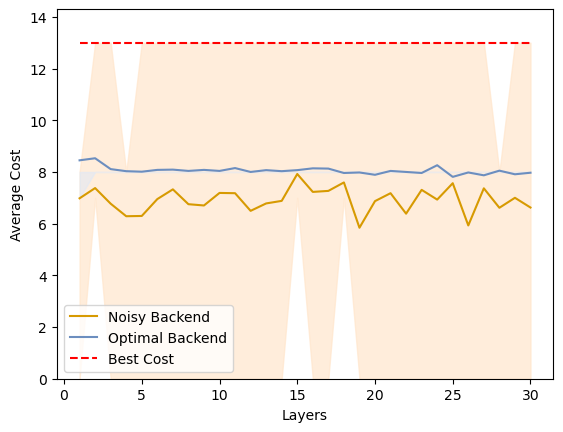

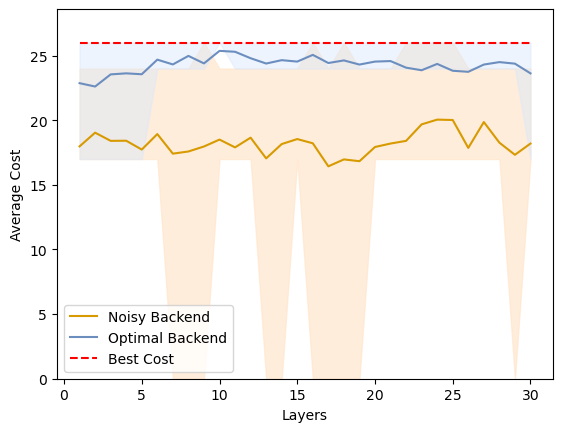

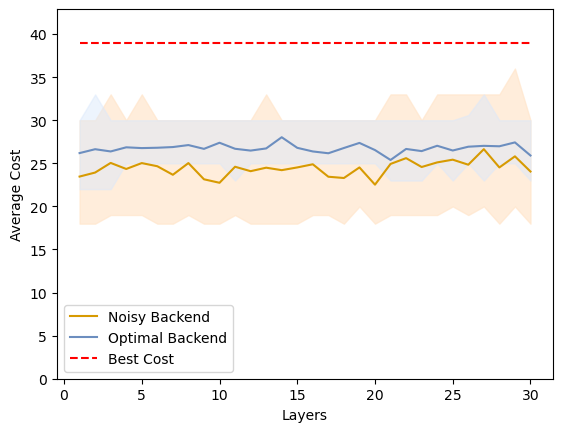

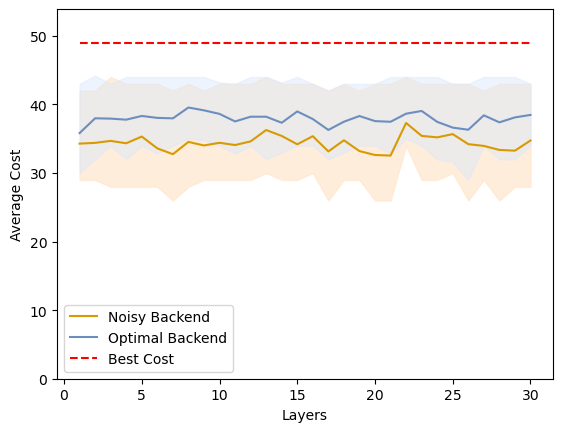

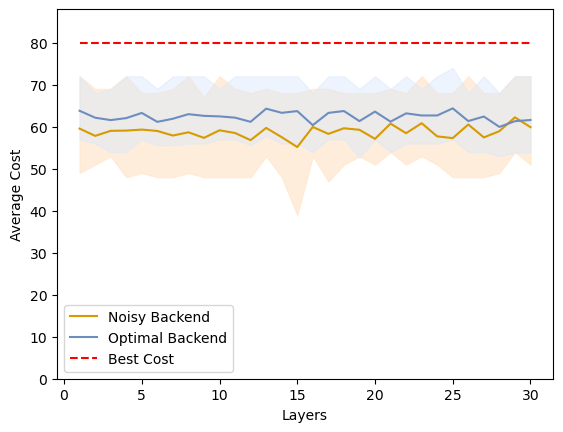

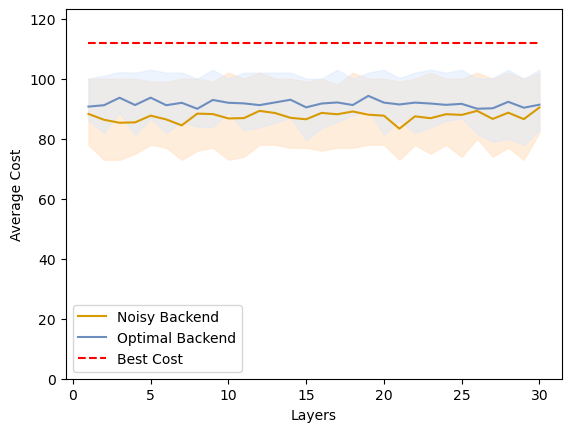

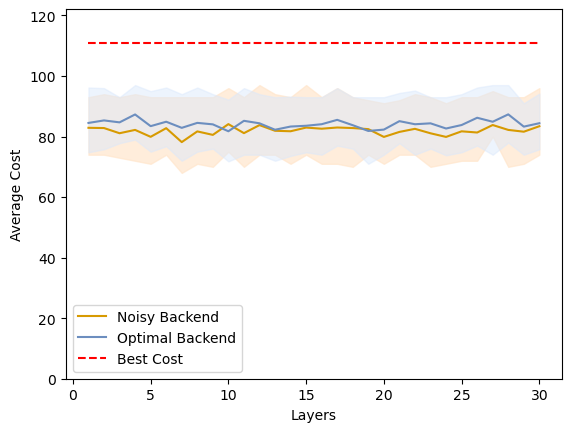

In [20]:
for number_of_nodes in range(3,10):
    plot_average_optimal_noisy(number_of_nodes)


In [21]:
custom_colors = qtee.utils.custom_colors

def map_tolerance_to_color(tolerance = None, iterations = None):
    if tolerance is not None:
        color_map = {
            'None': 'blue',
            '0.01': 'green',
            '0.001': 'orange',
            '0.0001': 'red',
            '1e-05': 'purple',
            '1e-06': 'purple'
        }
        return custom_colors[color_map[tolerance]]
    elif iterations is not None:
        color_map = {
            'Nonei': 'blue',
            '200i': 'green',
            '400i': 'orange',
            '800i': 'red',
            '1200i': 'purple',
        }
        return custom_colors[color_map[iterations]]

def plot_average_costs(data, best_cost=None, custom_colors=False, custom_legend=None, title=None):
    if custom_colors:
        for key, df in data.items():
            color_key = key.split('_')[-2]
            # color_key = color_key.split('/')[0]
            color = map_tolerance_to_color(iterations=color_key)['dark']
            plt.plot(df['layers'], -df['cost'], label=key, color=color)

    else:
        for key, df in data.items():
            plt.plot(df['layers'], -df['cost'], label=key)
            
    if best_cost:
        point1 = (1, best_cost)
        point2 = (30, best_cost)
        max_value_line = [point1, point2]
        plt.plot(*zip(*max_value_line), color='red', linestyle='--', label='Best Cost')
        plt.ylim(0, best_cost+ 0.1*best_cost)
    plt.xlabel('Layers')
    plt.ylabel('Average Cost')
    if custom_legend:
        plt.legend(custom_legend)
    else:
        plt.legend()
    if title:
        plt.title(title)
    return plt

def plot_average_options(list_of_options):
    problem = None
    data = {}
    data_layers = {}
    for option in list_of_options:
        dfs = load_dfs_from(option)
        combined_df = combine_dfs(dfs)
        
        if problem is None:
            problem = qtee.ProblemGenerator.from_dict(eval(dfs[0].iloc[0]['problem']))
        
        corrected_df = reverse_results(combined_df)
        average_df = compute_average_cost_and_time(corrected_df)
        data[option] = average_df
        layers_df = get_costs_and_times(corrected_df)
        data_layers[option] = layers_df
    
    custom_legend = []
    tolerance = None
    for option in list_of_options:
        parts = option.split("_")
        maxiter = parts[-2] if parts[-2] not in ['None', 'Nonei'] else 'default'
        parts = parts[-1].split("/")
        tolerance = parts[-2] if parts[-2] not in ['None', 'Nonei'] else 'default'
        # custom_legend.append(f'maxiter={maxiter} tolerance={tolerance}')
        custom_legend.append(f'{maxiter} iterations')
        # custom_legend.append(f'{maxiter} iterations')
        # custom_legend.append(None)
        tolerance = tolerance
    # title = f'{problem.n} Node Max-Cut, {tolerance} Tolerance'
    title = f'{problem.n} Node Max-Cut, {tolerance} Tolerance'

    custom_legend.append('Best Cost')
    # plt = plot_average_costs(data, problem.solution[1], custom_colors=True, custom_legend=custom_legend, title=title)
    # plt.savefig(f'plots/average_costs_{problem.n}nodes_{tolerance}tol.pdf')
    plt = plot_average_costs_with_ci(data_layers, problem.solution[1], percentile=80, smoothing_factor=1, custom_legend=custom_legend)
    plt.title(title)
    # plt.legend(custom_legend)
    plt.savefig(f'plots/average_costs_{problem.n}nodes_{tolerance}tol_ci.pdf')
    # plt = plot_average_times(data)
    # plt.title(title)
    # plt.legend(custom_legend)
    # plt.savefig(f'plots/average_times_{problem.n}nodes_{tolerance}tol.pdf')
    # print(data_layers)
    plt.show()




In [23]:
def plot_average_costs_with_ci(data, best_cost=None, percentile=80, smoothing_factor=1, custom_legend = None):
    alpha = 1
    legend_handles = []
    for key, df in data.items():
        # Calculate mean and percentiles for each layer
        df = df.explode('cost').reset_index(drop=True)
        df['cost'] = df['cost'].astype(float)
        summary = df.groupby('layers').agg(
            mean_cost=('cost', 'mean'),
            lower_percentile=('cost', lambda x: np.percentile(x, (100 - percentile) / 2)),
            upper_percentile=('cost', lambda x: np.percentile(x, 100 - (100 - percentile) / 2))
        ).reset_index()
        color_key = key.split('_')[-2]
        dark_color = map_tolerance_to_color(iterations=color_key)['dark']
        light_color = map_tolerance_to_color(iterations=color_key)['light']

        line_plot, = plt.plot(
            summary['layers'], 
            summary['mean_cost'], 
            # label=key if alpha == 1 else None,  # Add label only for the first plot
            color=dark_color
        )
        legend_handles.append(line_plot)
        # Smoothing the lower and upper percentiles
        lower_smoothed = summary['lower_percentile'].rolling(window=smoothing_factor, min_periods=1).mean()
        upper_smoothed = summary['upper_percentile'].rolling(window=smoothing_factor, min_periods=1).mean()
        
        plt.fill_between(
            summary['layers'], 
            lower_smoothed, 
            upper_smoothed, 
            color=light_color, 
            alpha=alpha
        )
        alpha /= 1.5
    
    if best_cost:
        point1 = (1, best_cost)
        point2 = (30, best_cost)
        max_value_line = [point1, point2]
        max_line, = plt.plot(*zip(*max_value_line), color='red', linestyle='--', label='Best Cost')
        legend_handles.append(max_line)
        plt.ylim(0, best_cost+ 0.1*best_cost)
        # plot the 87.856% line as the best classical approximation
        point1 = (1, 0.87856*best_cost)
        point2 = (30, 0.87856*best_cost)
        max_value_line = [point1, point2]
        max_line, = plt.plot(*zip(*max_value_line), color='blue', linestyle='--', label='Best Classical Approximation')
        legend_handles.append(max_line)
        custom_legend.append('Best Classical Approximation')

    plt.xlabel('Layers')
    plt.ylabel('Average Cost')
    # plt.title('Average Costs with Confidence Intervals')
    if custom_legend:
        plt.legend(handles=legend_handles, labels=custom_legend)
    else:
        plt.legend()
    return plt

In [24]:
def plot_average_times(data):
    for key, df in data.items():
        color_key = key.split('_')[-2]
        dark_color = map_tolerance_to_color(iterations=color_key)['dark']
        plt.plot(df['layers'], df['average_time'], label=key, color= dark_color)
    plt.xlabel('Layers')
    plt.ylabel('Average Time (s)')
    plt.legend()
    return plt

In [25]:
iterations = ['None', 200, 400, 800, 1200]
tolerances = ['None', 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]



In [16]:
# for number_of_nodes in range(3, 10):
#     print(f'Plotting for {number_of_nodes} nodes')
#     for iteration in iterations:
#         print(f'Plotting for {iteration} iterations')
#         options = [f'results_maxcut_{number_of_nodes}_{iteration}i_{tolerance}/optimal' for tolerance in tolerances]
#         plot_average_options(options)

Plotting for 3 nodes
Plotting for None tolerance


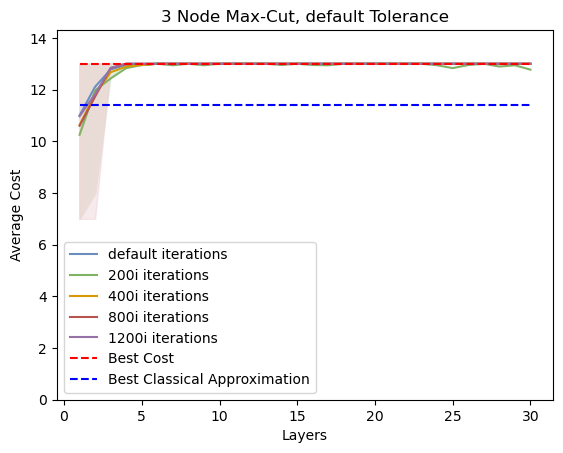

Plotting for 0.01 tolerance


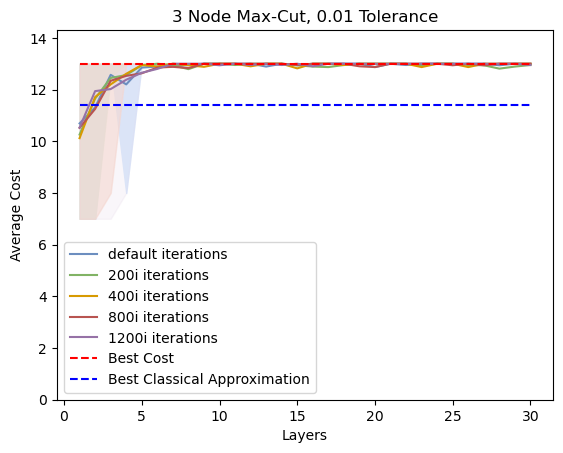

Plotting for 0.001 tolerance


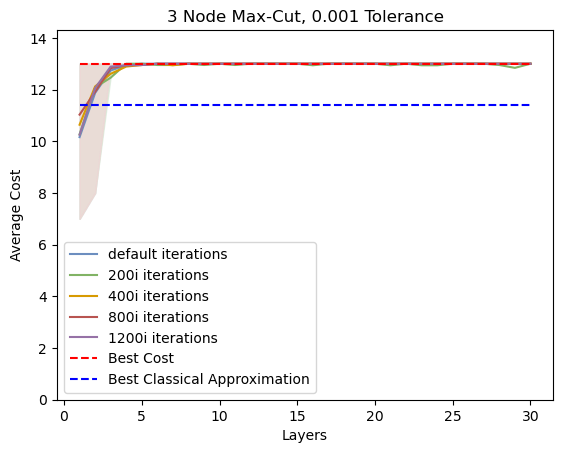

Plotting for 0.0001 tolerance


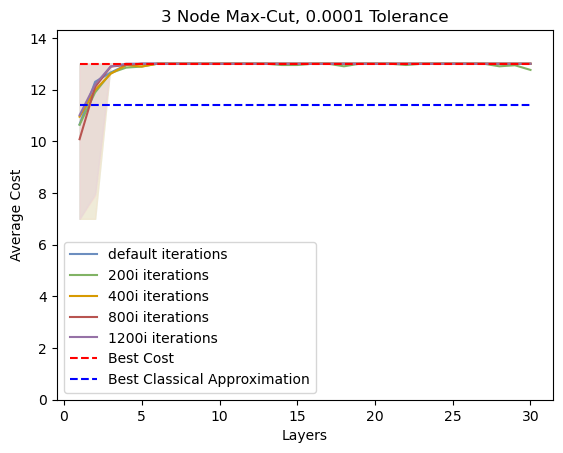

Plotting for 1e-05 tolerance


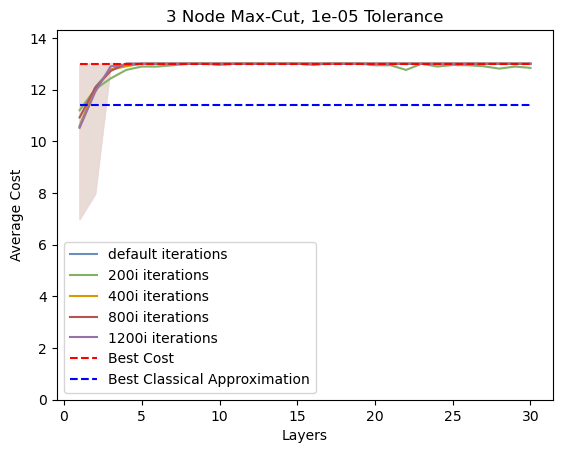

Plotting for 1e-06 tolerance


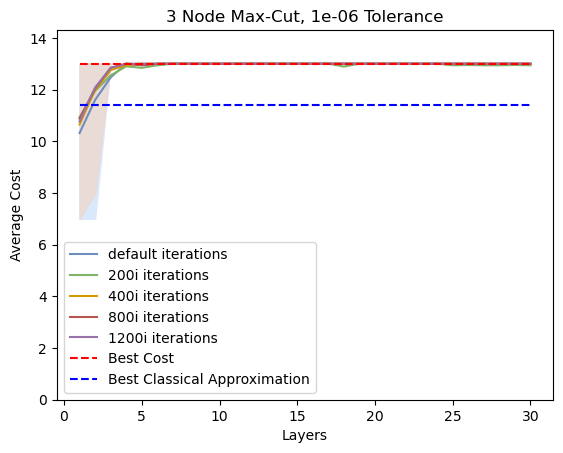

Plotting for 4 nodes
Plotting for None tolerance


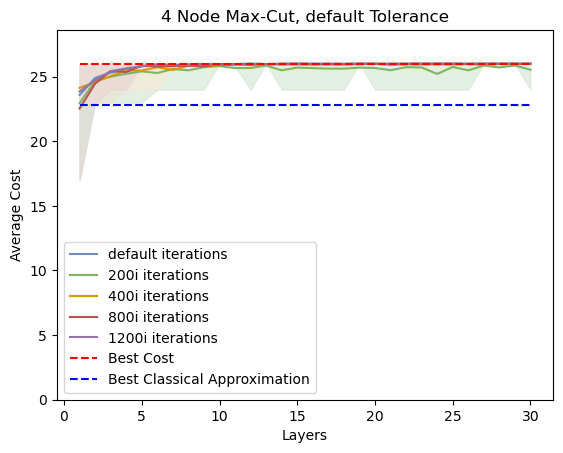

Plotting for 0.01 tolerance


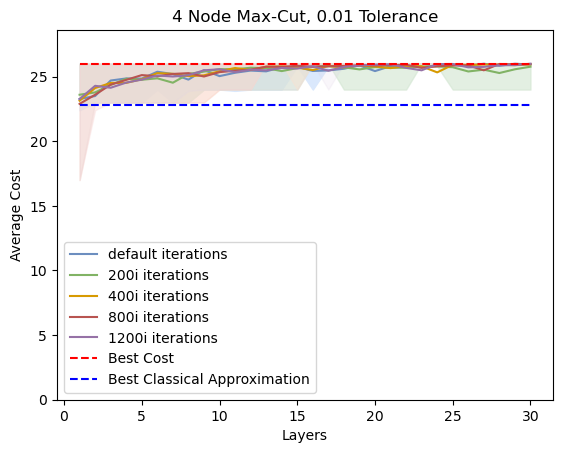

Plotting for 0.001 tolerance


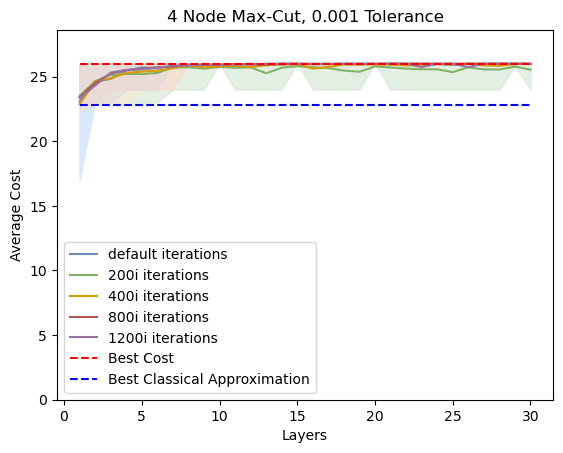

Plotting for 0.0001 tolerance


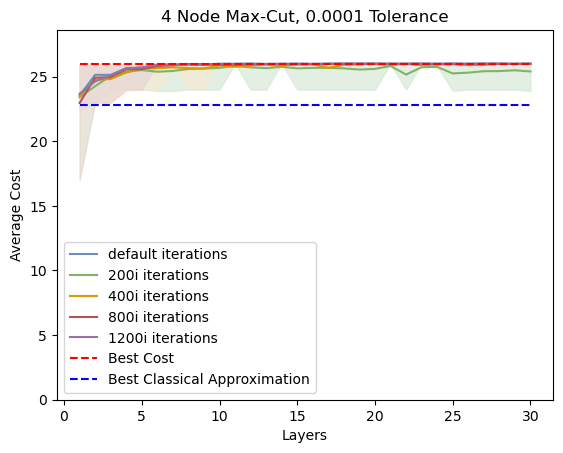

Plotting for 1e-05 tolerance


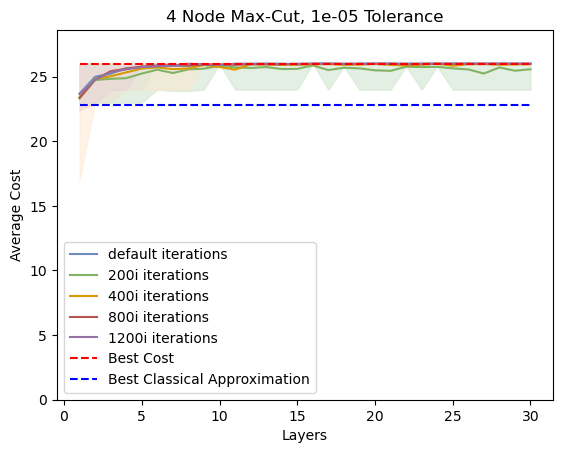

Plotting for 1e-06 tolerance


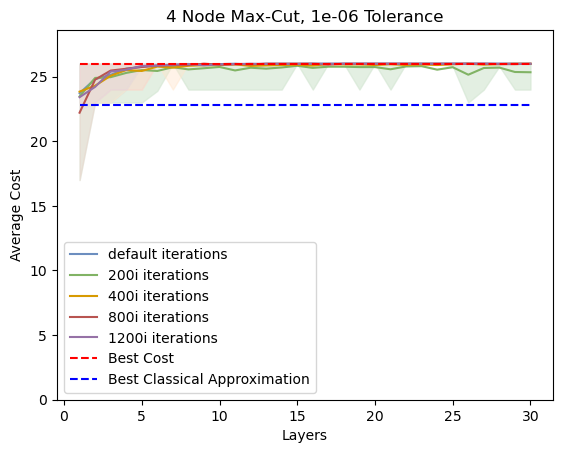

Plotting for 5 nodes
Plotting for None tolerance


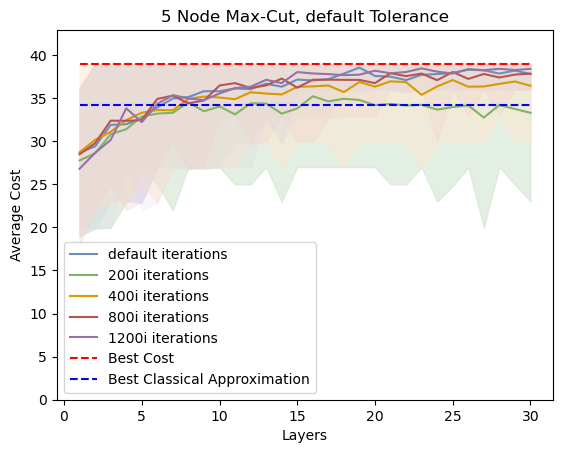

Plotting for 0.01 tolerance


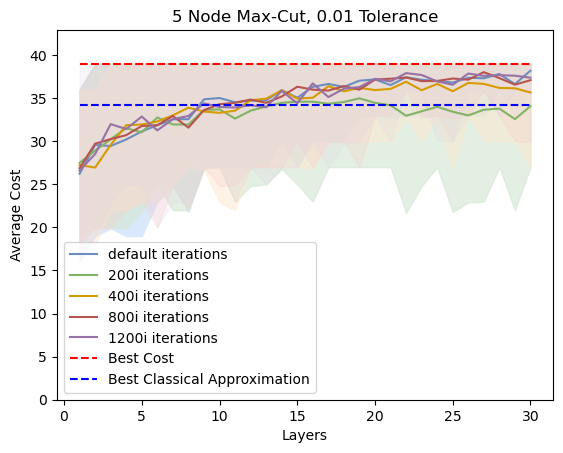

Plotting for 0.001 tolerance


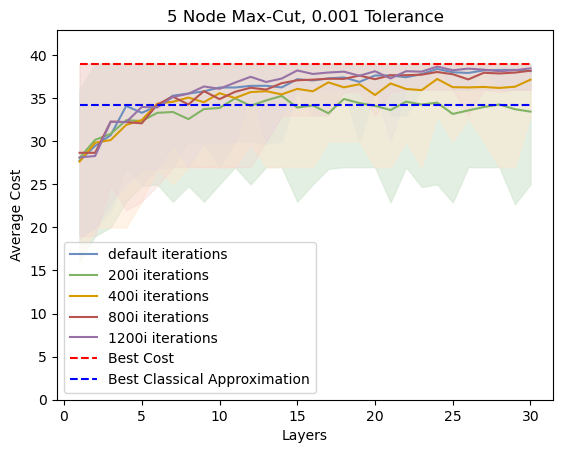

Plotting for 0.0001 tolerance


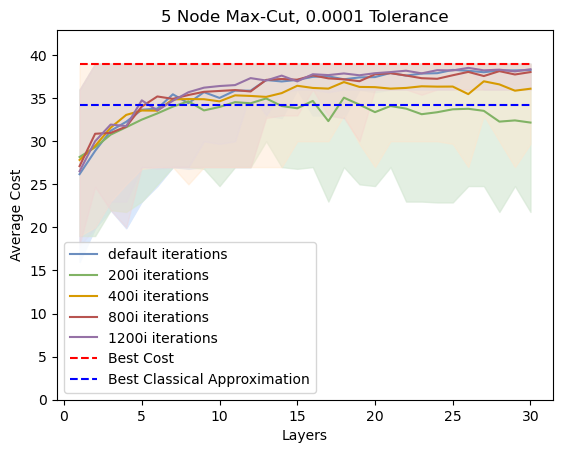

Plotting for 1e-05 tolerance


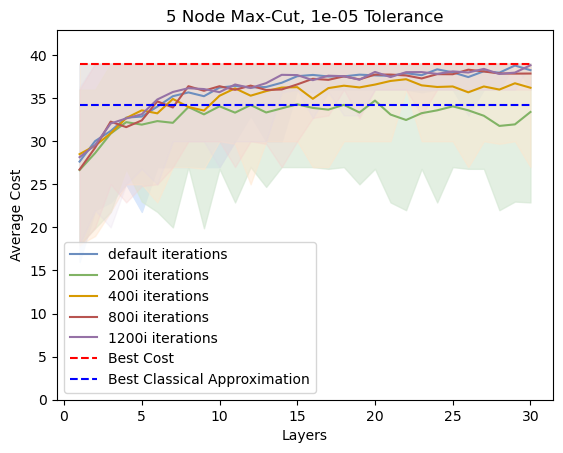

Plotting for 1e-06 tolerance


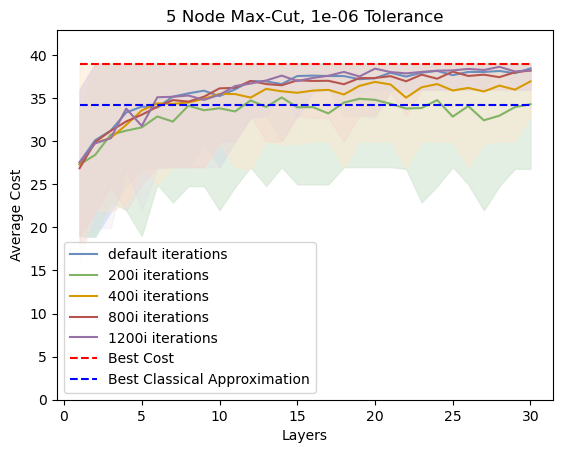

Plotting for 6 nodes
Plotting for None tolerance


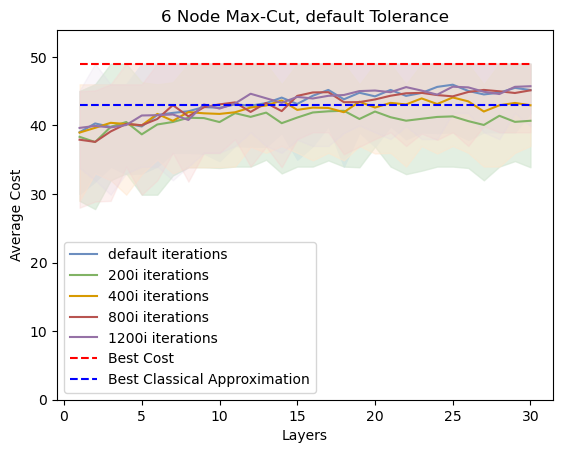

Plotting for 0.01 tolerance


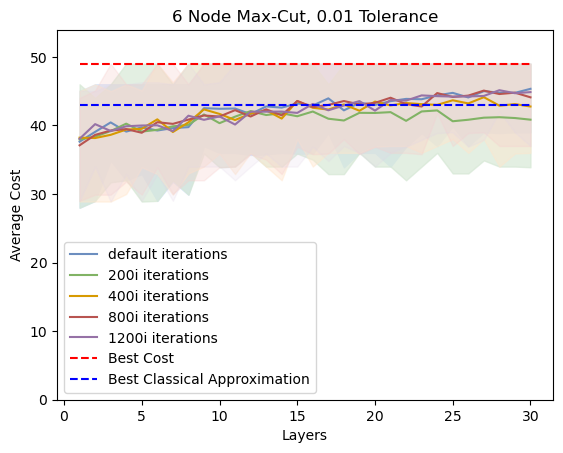

Plotting for 0.001 tolerance


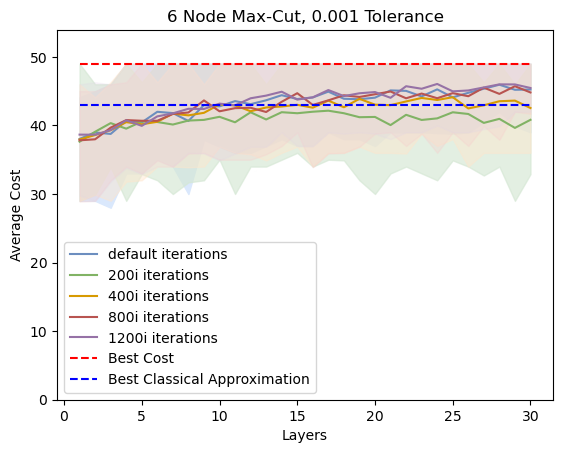

Plotting for 0.0001 tolerance


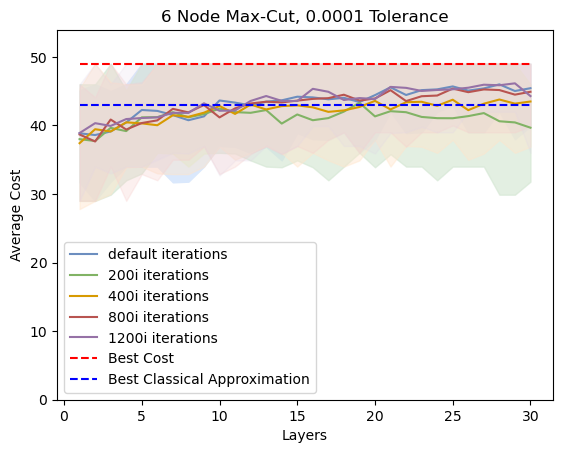

Plotting for 1e-05 tolerance


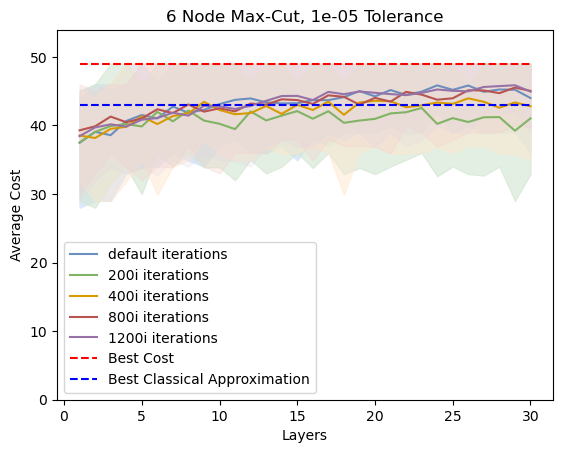

Plotting for 1e-06 tolerance


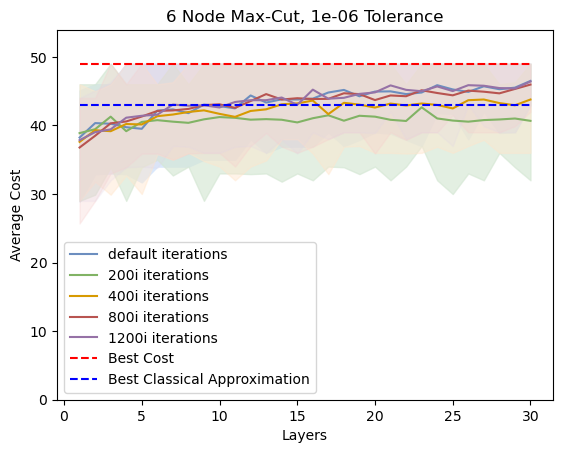

Plotting for 7 nodes
Plotting for None tolerance


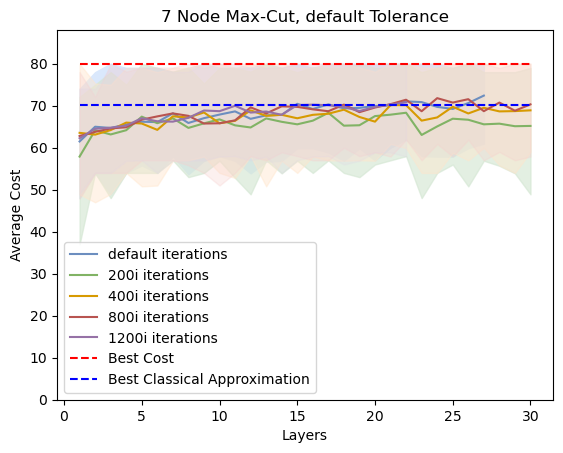

Plotting for 0.01 tolerance


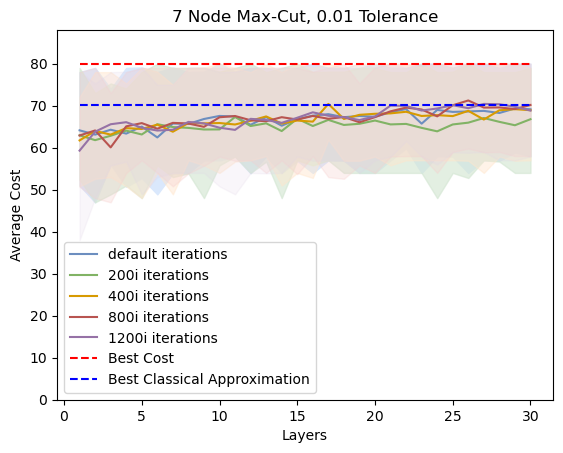

Plotting for 0.001 tolerance


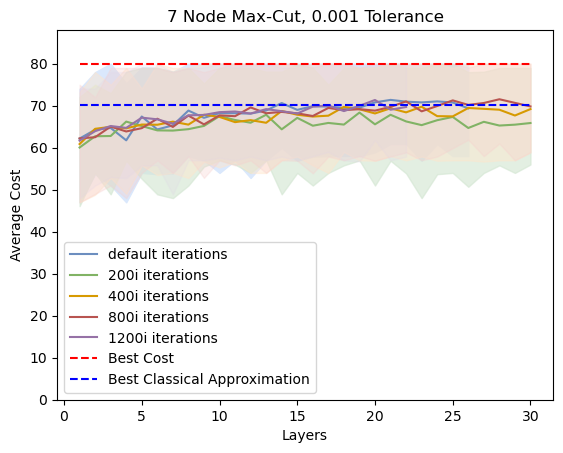

Plotting for 0.0001 tolerance


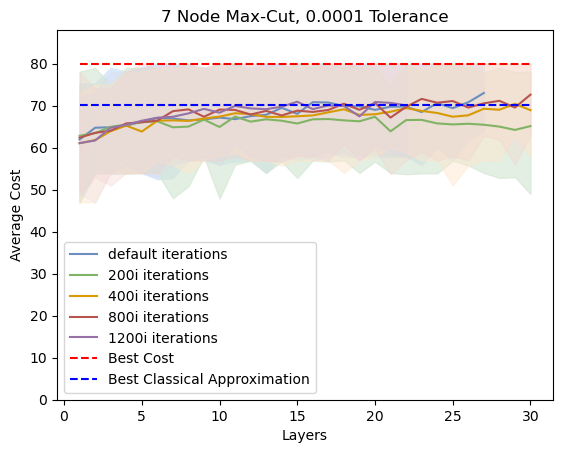

Plotting for 1e-05 tolerance


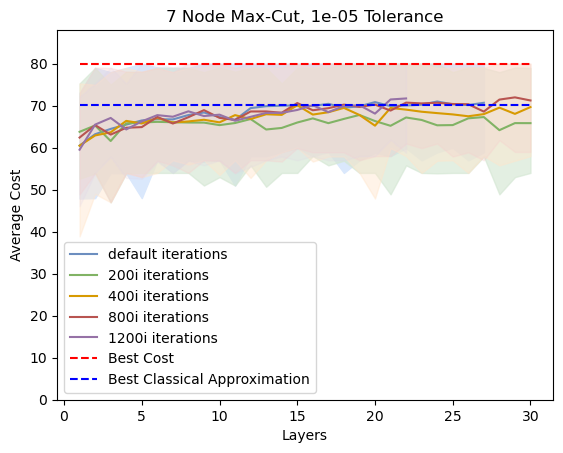

Plotting for 1e-06 tolerance


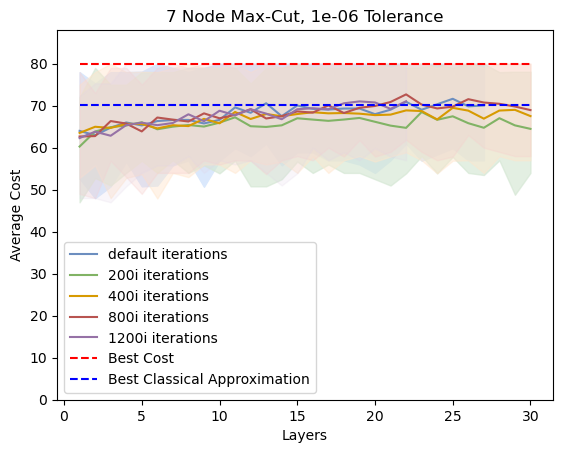

Plotting for 8 nodes
Plotting for None tolerance


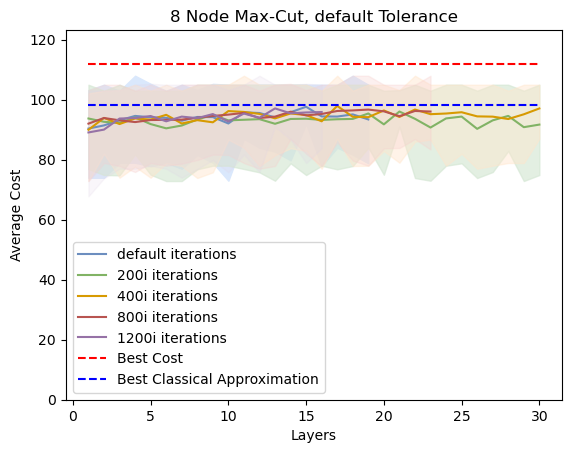

Plotting for 0.01 tolerance


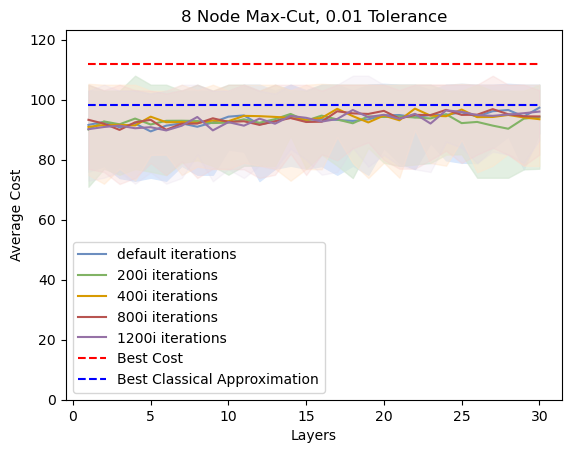

Plotting for 0.001 tolerance


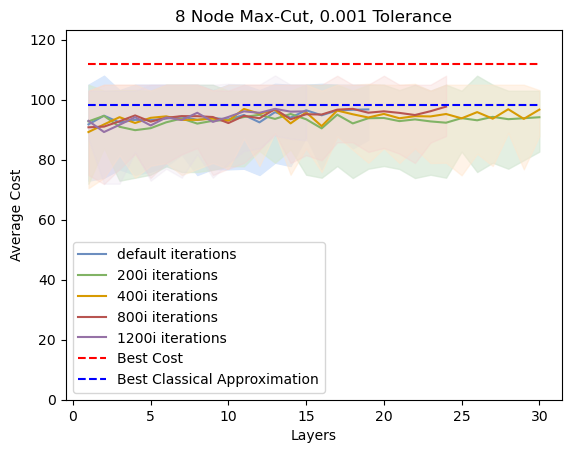

Plotting for 0.0001 tolerance


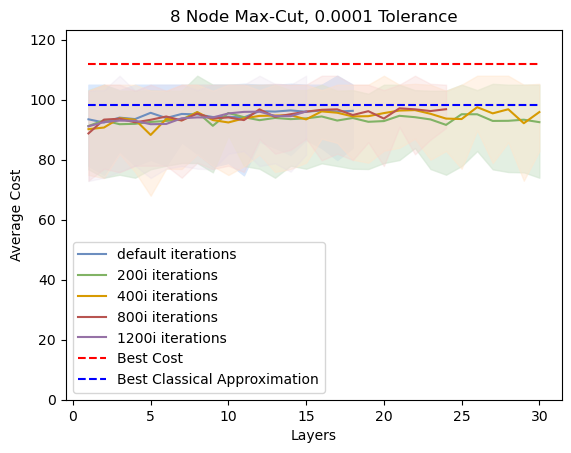

Plotting for 1e-05 tolerance


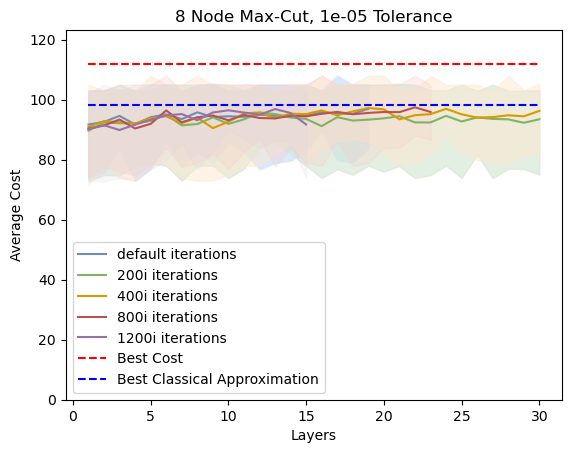

Plotting for 1e-06 tolerance


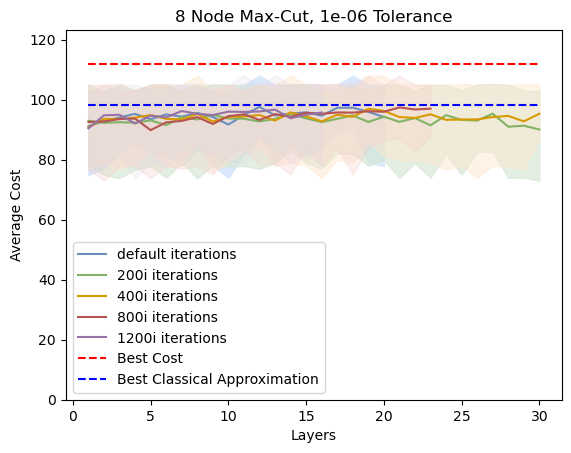

Plotting for 9 nodes
Plotting for None tolerance


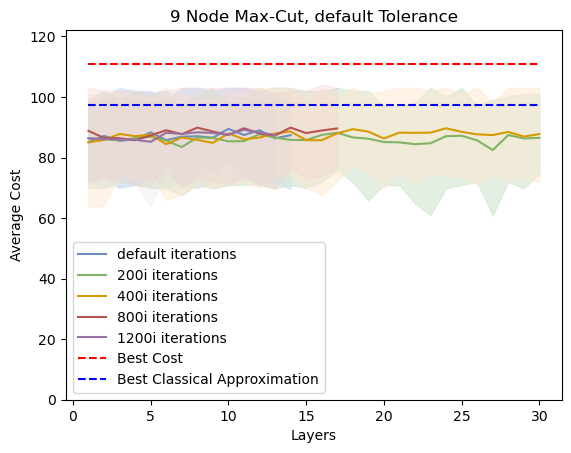

Plotting for 0.01 tolerance


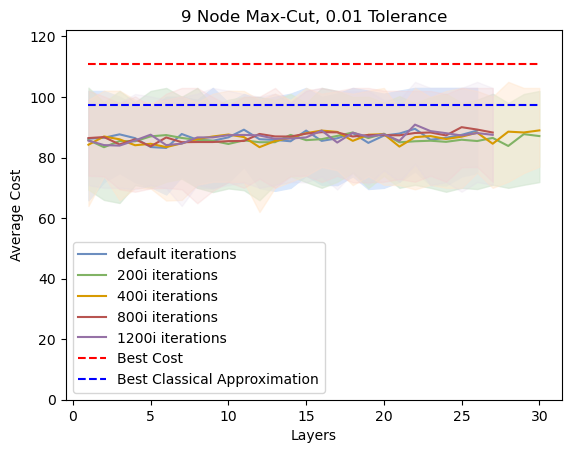

Plotting for 0.001 tolerance


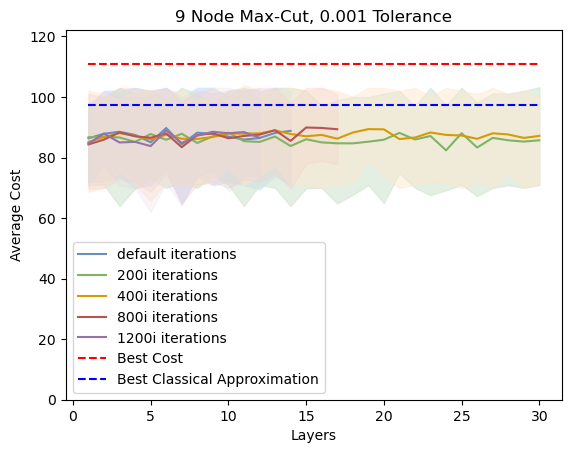

Plotting for 0.0001 tolerance


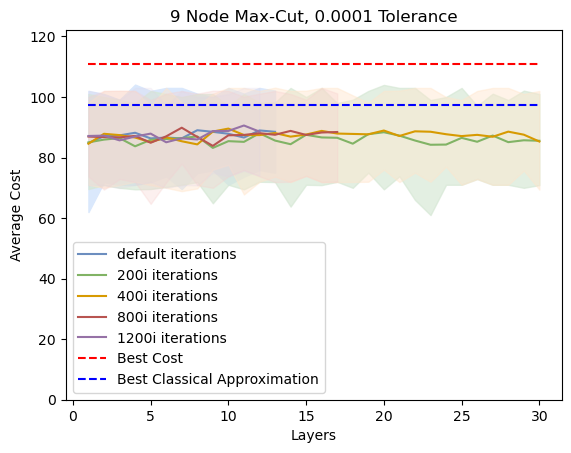

Plotting for 1e-05 tolerance


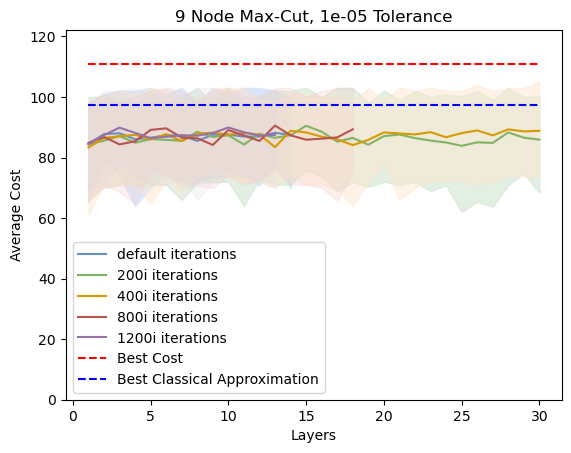

Plotting for 1e-06 tolerance


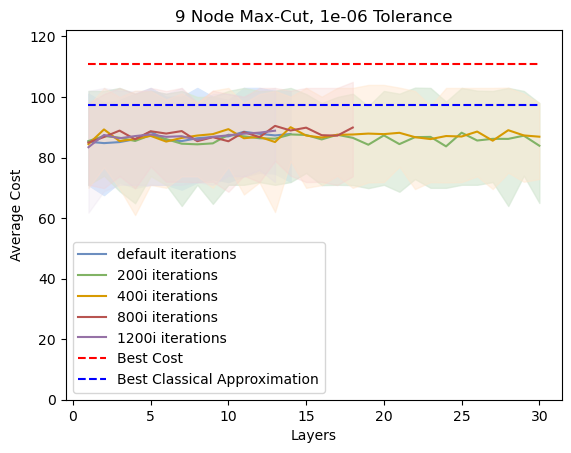

In [26]:
for number_of_nodes in range(3, 10):
    print(f'Plotting for {number_of_nodes} nodes')
    for tolerance in tolerances:
        print(f'Plotting for {tolerance} tolerance')
        options = [f'results_maxcut_{number_of_nodes}_{iteration}i_{tolerance}/optimal' for iteration in iterations]
        plot_average_options(options)

### Creating a Table containing the average accuracy for each problem and layer combination

In [27]:
def to_accuracy(df, best_cost):
    df = df.copy()
    # df['cost'] = df['cost'] * -1
    df['accuracy'] = df['cost'] / best_cost

    df['accuracy_strings'] = df['accuracy'].apply(lambda x: f'{x:.2%}')

    # Identify the highest accuracy
    max_accuracy = df['accuracy'].max()
    
    # Apply the text formatting
    df['accuracy_strings'] = df.apply(
        lambda row: f'\\textbf{{{row["accuracy_strings"]}}}' if row['accuracy'] == max_accuracy else row['accuracy_strings'], 
        axis=1
    )

    # Drop all columns except layers and accuracy_strings
    df = df[['layers', 'accuracy_strings']]
    # Make layers the index
    df.set_index('layers', inplace=True)
    # Replace % with \% and NaN with N/A
    df = df.replace('%', '\%', regex=True)
    return df


In [ ]:
def count_valid_solutions(df):
    

In [76]:
combined_df = pd.DataFrame()
for number_of_nodes in range(3,10):
    optimal_dfs = load_dfs_from(f'results_maxcut_{number_of_nodes}_1200i_1e-06/optimal')
    optimal_df = combine_dfs(optimal_dfs)
    # corrected_optimal = dont_reverse(optimal_df)
    corrected_optimal = reverse_results(optimal_df)
    # corrected_optimal = only_solution(optimal_df)
    # print(corrected_optimal)
    optimal_average = compute_average_cost_and_time(corrected_optimal)
    print(number_of_nodes)
    print(optimal_average)
    problem = qtee.ProblemGenerator.from_dict(eval(optimal_dfs[0].iloc[0]['problem']))
    best_cost = problem.solve_qubo()[1]
    print(-best_cost)
    accuracy_df = to_accuracy(optimal_average, best_cost)
    # add column from accuracy_df to combined_df
    combined_df = pd.concat([combined_df, accuracy_df], axis=1)
    # also add the number of correct solutions from optimal_average['none_count']
    # correct_solutions = pd.DataFrame({'Correct Solutions': [optimal_average['none_count']]}, index=accuracy_df.index)
    # correct_solutions = optimal_average['none_count']
    # increase the index by 1
    # correct_solutions.index += 1
    # Create a MultiIndex for the new columns
    # new_columns = pd.MultiIndex.from_product([[f'{number_of_nodes} Nodes'], ['Accuracy', 'Valid Solutions']])
    
    # Concatenate accuracy and correct solutions under the new MultiIndex
    # combined_data = pd.concat([accuracy_df, correct_solutions], axis=1)
    # combined_data.columns = new_columns
    
    # Concatenate the combined data with the main DataFrame
    # combined_df = pd.concat([combined_df, combined_data], axis=1)

# Set the index name to 'Layers'
# combined_df.index.name = 'Layers'


combined_df.columns = [f'{number_of_nodes} Nodes' for number_of_nodes in range(3,10)]
# rename index to layers and start from 1
combined_df.index.name = 'Layers'


3
    layers   cost  average_time  none_count
0        1 -10.77      0.630171         100
1        2 -12.08     11.158703         100
2        3 -12.84     24.893646         100
3        4 -13.00     30.094244         100
4        5 -13.00     35.902180         100
5        6 -13.00     38.270482         100
6        7 -13.00     42.954160         100
7        8 -13.00     46.200168         100
8        9 -13.00     49.135341         100
9       10 -13.00     52.943976         100
10      11 -13.00     70.182304         100
11      12 -13.00     62.592970         100
12      13 -13.00     67.609560         100
13      14 -13.00     90.676736         100
14      15 -13.00     78.859247         100
15      16 -13.00     85.496407         100
16      17 -13.00     95.695269         100
17      18 -13.00    103.248627         100
18      19 -13.00    108.965820         100
19      20 -13.00    120.573470         100
20      21 -13.00    122.516145         100
21      22 -13.00    132.53322

In [77]:
combined_df

,3 Nodes,4 Nodes,5 Nodes,6 Nodes,7 Nodes,8 Nodes,9 Nodes
Layers,,,,,,,
1,82.85\%,90.04\%,70.59\%,77.24\%,77.88\%,80.79\%,75.14\%
2,92.92\%,93.12\%,76.31\%,79.63\%,79.77\%,84.65\%,78.80\%
3,98.77\%,97.65\%,77.82\%,80.47\%,78.56\%,84.80\%,77.81\%
4,\textbf{100.00\%},98.19\%,86.64\%,83.94\%,81.74\%,82.20\%,78.47\%
5,\textbf{100.00\%},99.35\%,81.49\%,84.51\%,82.45\%,84.54\%,78.95\%
6,\textbf{100.00\%},99.42\%,90.03\%,84.84\%,81.71\%,84.04\%,78.24\%
7,\textbf{100.00\%},99.73\%,90.15\%,87.84\%,82.36\%,85.93\%,78.42\%
8,\textbf{100.00\%},99.92\%,90.54\%,87.49\%,84.95\%,85.07\%,77.32\%
9,\textbf{100.00\%},99.50\%,89.23\%,87.63\%,82.89\%,84.73\%,78.23\%


In [78]:
combined_df.to_csv('tables/maxcut_1200i_1e-06.csv')

In [ ]:
tests = {
    'Name': {
        'path': 'path/to/files',
        'color': 'color_name',
        'label': 'label_name',
        'reverse_results': True,
    }
}